# Adaptive Model : Dynamic & Global

**Libraries**

In [1]:
from evaCure import main, parameters

**Parameters**

In [238]:
conn = {'connAd': '/home/golos/Main/Connectomes/Jonathan/86/SCE/p05.txt',
        'normC': 1.}

noise = {'stdD_x': 0.2,
         'stdD_T': 0.4,
         'colors': ['white','white']}

model = {'dt': 1.,
         'model': 'HopfieldBasedDynamic',
         'tauT': 80,
         'threshold': 'global',
         'P': 0.6,
         'G': 900}

out = ['x', 'A', 'rtime', 'theta']

other = {'init': 'rand',
         'dens': 0.1,
         'rperiod': 10,}

TF = 100*1000 # 1 ms

**Initialization**

In [92]:
eva = main.evaCure(evaCon=conn, evaNoi=noise, evaMod=model, out=out, **other)

**Run**

In [93]:
# 10 min
Td.tic()
for i in range(TF):
    eva.update()
    Td.estimAndPercent(i, TF)
Td.tac()

Time estimated: 0h00min11s
(10%), time elapsed: 0.76s
(20%), time elapsed: 1.52s
(30%), time elapsed: 2.27s
(40%), time elapsed: 3.02s
(50%), time elapsed: 3.77s
(60%), time elapsed: 4.52s
(70%), time elapsed: 5.28s
(80%), time elapsed: 6.04s
(90%), time elapsed: 6.79s
(100%), time elapsed: 7.55s
Time elapsed: 7.55s


---
# Display

In [94]:
T1 = 0
T2 = -1
t = array(eva.out['rtime'][T1:T2]) * eva.evaMod.dt / 1000 #s
x = array(eva.out['x'][T1:T2])
A = array(eva.out['A'][T1:T2])
theta = array(eva.out['theta'][T1:T2])

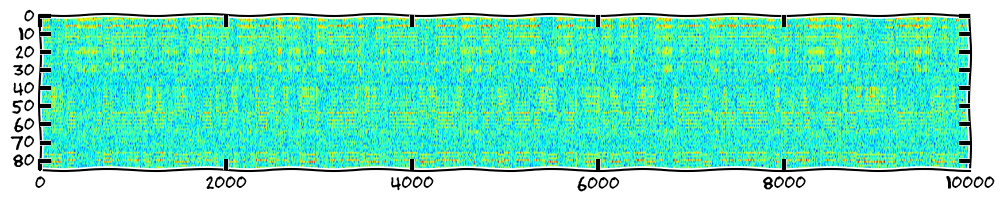

In [95]:
figure(figsize=(12,2)); imshow(x.T, aspect='auto');
# figure(figsize=(12,2)); imshow(A.T, aspect='auto') 
# figure(figsize=(12,2)); plot(t, A.mean(1)) ; plot(t, theta) ; plot(t, x.mean(1)) ; show()

In [96]:
hrf = Tp.HRF(ms=10)
BO = zeros(x.shape)
for k in range(x.shape[1]):
    BO[:,k] = convolve(x[:,k], hrf)[:len(x)]
BO = BO[100:]
BOa = Tf.mvAvg(BO, 10)

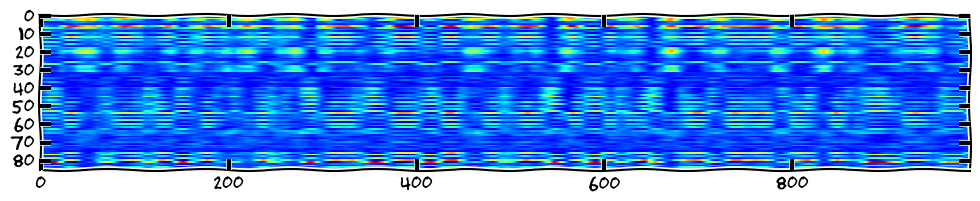

In [97]:
figure(figsize=(12,2)); imshow(BOa.T, aspect='auto', interpolation='nearest');

## Attractors

In [98]:
V,PC = Tf.fPCA(x)
CPC = array([BO.dot(PC[p]) for p in range(len(PC))])

In [99]:
prct = 100. / V.sum()
print '3 Principals: %i%% + %i%% + %i%% = %i%%' %(V[0]*prct, V[1]*prct, V[2]*prct, V[:3].sum()*prct)

3 Principals: 23% + 11% + 3% = 38%


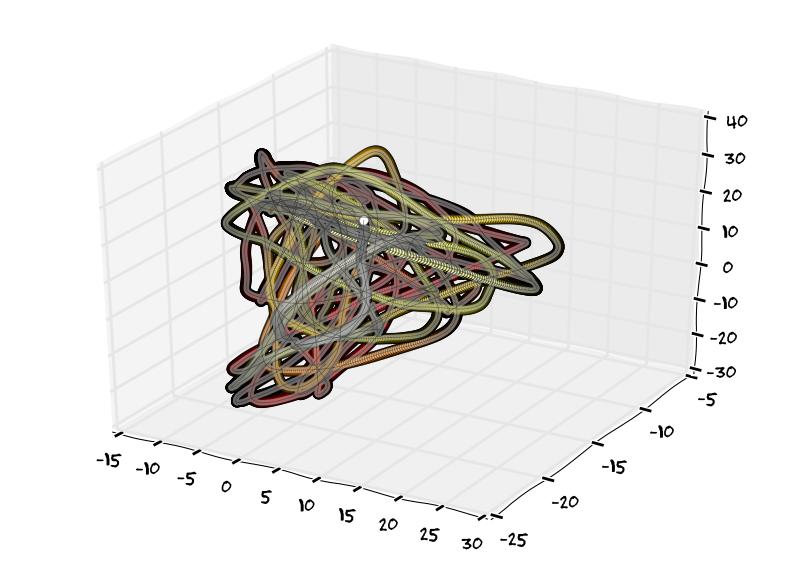

In [100]:
S = [CPC[0], CPC[1], CPC[2]]; shuffle(S)
Td.plot4D(S[0], S[1], S[2], 'hot', kwaSca={'s':50}, fig=figure(figsize=(10,7)), line=1)

## Co-Activités

In [101]:
xL = Tf.windowedFCs(BOa, window=45)

In [102]:
xL = array([Tf.triSup(FCi) for FCi in xL])

In [103]:
xL = xL[20:]

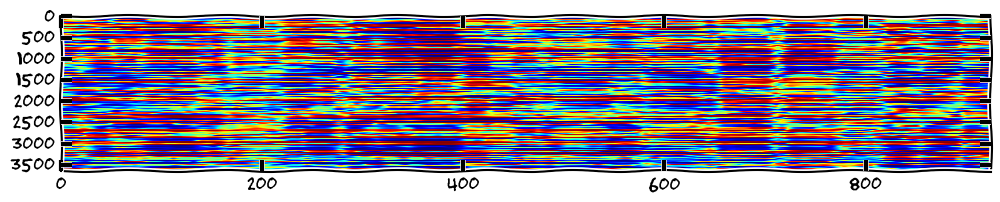

In [104]:
figure(figsize=(12,2)); imshow(xL.T, aspect='auto', interpolation='nearest');

## MFC

In [105]:
MFC = Tf.fPearsonCorrelation(xL)
# MFC = abs(MFC)

In [ ]:
# imshow(MFC);

In [107]:
import scipy.cluster.hierarchy as sch
Y = sch.linkage(MFC, method='centroid')

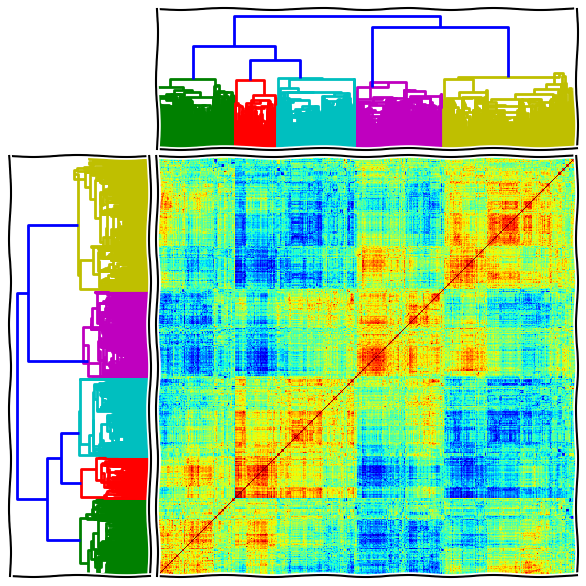

In [108]:
fig, tK = figure(figsize=(7,7)), 0.6

ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
Z = sch.dendrogram(Y, color_threshold=tK*max(Y[:,2]), orientation='left')
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Z = sch.dendrogram(Y, color_threshold=tK*max(Y[:,2]))
ax2.set_xticks([])
ax2.set_yticks([])

axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
index = Z['leaves']
im = axmatrix.matshow(MFC[index][:,index], origin='lower')
axmatrix.set_xticks([])
axmatrix.set_yticks([]);

In [109]:
def couleur(origin):
    s = ''
    for N,n in zip(('Vert','Rouge','Cyan','Magenta','Jaune','Noir','Bleu'),('g', 'r', 'c', 'm', 'y', 'k', 'b')):
        s += eval("'%s'*(origin=='%s')" %(N,n))
    return s

In [110]:
lbls = [ couleur(Z['color_list'][0]) ]
clus = [[]]
for c, i in zip(Z['color_list'], range(len(index))):
    if couleur(c) != lbls[-1]:
        lbls.append( couleur(c) )
        clus.append([])
    clus[-1].append(i)
for i in range(len(clus))[::-1]:
    if len(clus[i]) < 20:
        del clus[i], lbls[i]
    else:
        lbls[i] += ' (%i)'%len(clus[i])
org = Td.sortBy([len(c) for c in clus], inverse=1)[0]
clus = [clus[i] for i in org]
lbls = [lbls[i] for i in org]
print lbls

['Jaune (1162)', 'Magenta (755)', 'Cyan (689)', 'Vert (675)', 'Rouge (369)']


In [111]:
DCFs = [ Tf.fPearsonCorrelation(xL[:,:].T) ]
for c in clus:
    DCFs.append( Tf.fPearsonCorrelation(xL[:,c].T) )

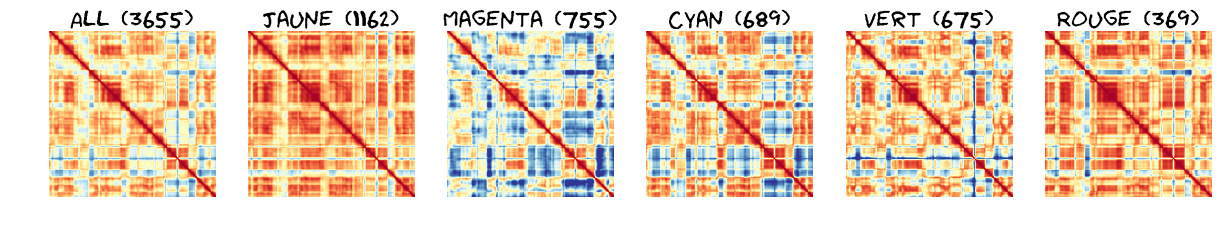

In [112]:
Td.mapMatrices(DCFs, lTitl=['All (%i)'%len(MFC)]+lbls, lign=1, fs=(15,7), axL=0, interpolation='nearest', vmin=0, vmax=1, cmap='RdYlBu_r')